# DVD Inversion exercise (InSAR- Low Noise)

This notebook solves DVD inversion exercise using the InSAR datasets

## Import libraries

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Joint
from vmod.source import Mctigue

## Read datasets

In [2]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [3]:
nx=401
ny=nx
losa=np.reshape(losa,(ny,nx))[:,::-1].T
losd=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [4]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc.txt',per=30,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des.txt',per=30,unit='m')

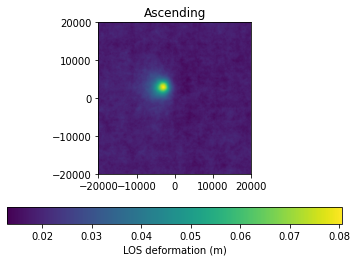

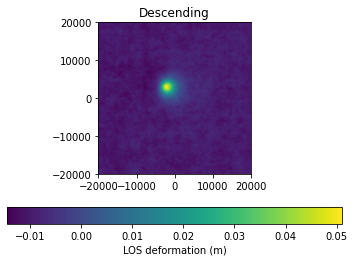

In [5]:
plt.figure()
plt.title('Ascending')
plt.imshow(losa,extent=extenta)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losd,extent=extentd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Reading downsampled data

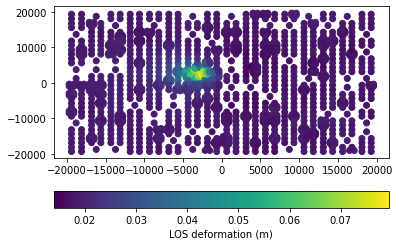

In [6]:
xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_high.txt')

plt.figure()
plt.scatter(xsa,ysa,c=losa)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

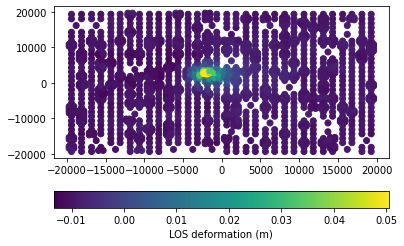

In [7]:
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_high.txt')

plt.figure()
plt.scatter(xsd,ysd,c=losd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Create data object

In [8]:
obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)

obs=Joint()
obs.add_dataset(obsa)
obs.add_dataset(obsd)

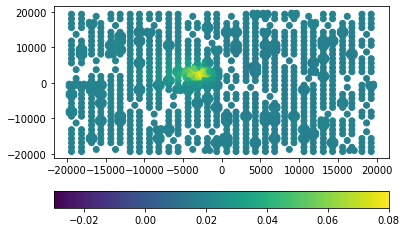

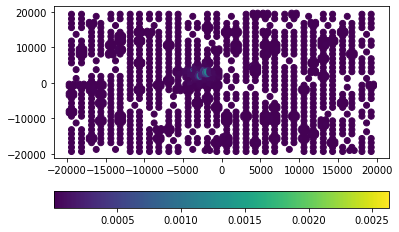

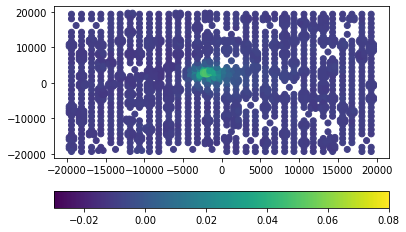

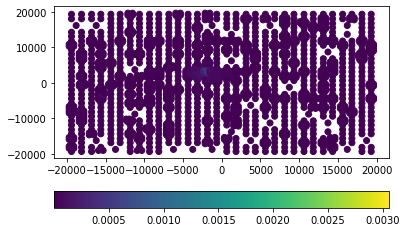

In [9]:
plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data(),vmin=-0.03,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=elosa)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data(),vmin=-0.03,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=elosd)
plt.colorbar(orientation='horizontal')

## Create model objects for each direction

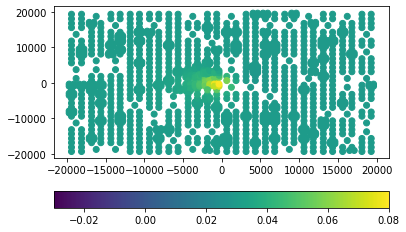

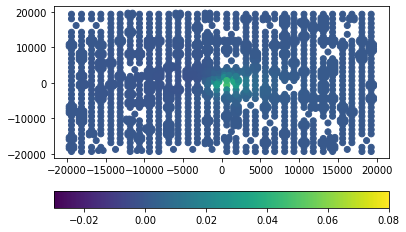

In [10]:
mcta=Mctigue(obsa)
mcta.add_offsets()
losm=mcta.forward([0,0,2.0e3,5e2,1e6,0.03])

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.03,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctd=Mctigue(obsd)
mctd.add_offsets()
losm=mctd.forward([0,0,2.0e3,5e2,1e6,0])

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.03,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Create object model for joint data

In [11]:
mct=Mctigue(obs)
mct.add_offsets()
mct.set_x0([0,0,2e3,5e2,1e6,0.01,-0.01])
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,1e5,0,-0.1], high_bounds = [20000,20000,9e4,5e3,1e8,0.1,0])

## Create Inversion object

In [ ]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least squares inversion

In [13]:
ans=inv.nlsq()

print(ans.x)

[-2.59156911e+03  2.91925496e+03  2.04376754e+03  9.79246852e+02
  1.12726702e+06  1.81647136e-02 -9.81581894e-03]


[-2.59156911e+03  2.91925496e+03  2.04376754e+03  9.79246852e+02
  1.12726702e+06  1.81647136e-02] [-2.59156911e+03  2.91925496e+03  2.04376754e+03  9.79246852e+02
  1.12726702e+06 -9.81581894e-03]


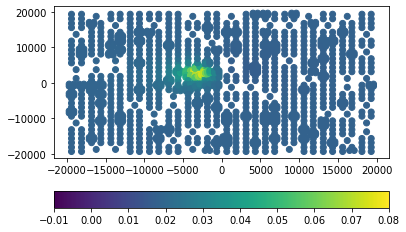

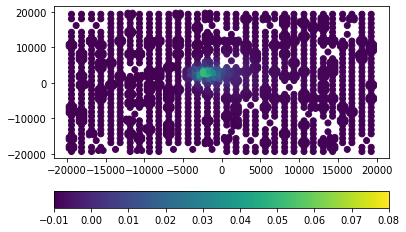

In [14]:
ansa=ans.x[0:len(ans.x)-1]
ansd=np.concatenate((ans.x[0:len(ans.x)-2],[ans.x[-1]]))
print(ansa,ansd)
losm=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

losm=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Bayesian inversion

In [15]:
trace,MDL=inv.mcmc('insar_low')

 [-----------------100%-----------------] 1100000 of 1100000 complete in 8667.4 sec

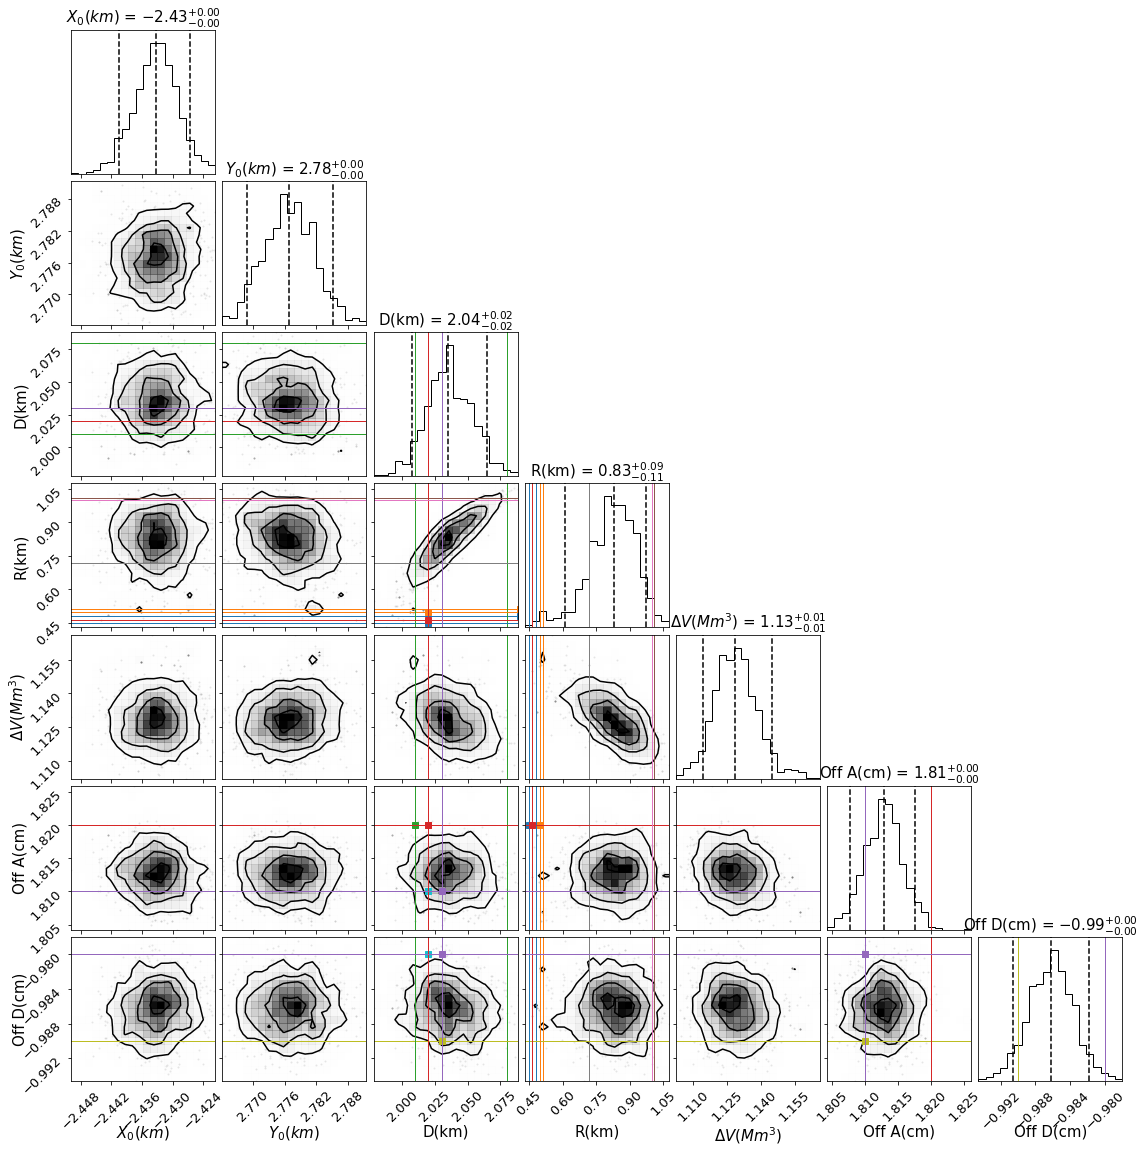

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]*1e2
data[6,:]=data[6,:]*1e2
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','$\Delta{V} (Mm^{3})$','Off A(cm)','Off D(cm)']

trus1=[-2.50,2.62,2.09,0.48,1.26,1.80,-1.00]
trus2=[-2.50,2.59,2.09,0.51,1.28,1.80,-1.00]
trus3=[-2.50,2.87,2.08,0,1.27,1.79,-1.01]
trus4=[-2.52,2.87,2.11,0,1.29,0,0]
trus5=[-2.51,2.87,2.10,0.5,1.29,1.79,-1.02]
trus6=[-2.52,2.87,2.18,1.01,1.28,0,0]
trus7=[-2.52,2.87,2.12,0.50,1.29,0,0]
trus8=[-2.50,2.86,2.12,0.72,1.27,0,0]
trus9=[-2.50,2.89,2.03,0.20,1.22,1.81,-0.99]
trus10=[-2.50,2.87,2.02,0.11,1.23,1.81,-0.98]
trus11=[-2.50,2.87,2.02,0.45,1.22,1.82,-0.97]
trus12=[-2.50,2.87,2.02,0.50,1.21,1.82,-0.97]
trus13=[-2.50,2.87,2.01,0.38,1.22,1.82,-0.97]
trus14=[-2.50,2.87,2.02,0.46,1.22,1.82,-0.97]
trus15=[-2.50,2.87,2.03,0.18,1.24,1.81,-0.98]
trus16=[-2.51,2.86,2.37,1.00,0,0,0]
trus17=[-1.46,2.82,2.11,1.00,1.04,1.83,-0.96]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

plt.rcParams.update({'font.size': 13})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,
                       show_titles=True, label_kwargs={"fontsize": 15}, title_kwargs={"fontsize": 15})

for i,tru in enumerate(trus):
    corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')

plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [19]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

meansP=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),50)
lower95P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),5)
upper95P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),95)
lower32P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),32)
upper68P=np.percentile(data[4,:]*4e9/(np.pi*data[3,:]**3),68)
print(means)
print(lower95)
print(upper95)
print(lower32)
print(upper68)

print(meansP)
print(lower95P)
print(upper95P)
print(lower32P)
print(upper68P)

[-2422.2167523912326, 2778.7855003281, 1978.1076540598497, 454.7826539775056, 1122666.7165599773]
[-2429.9277542530585, 2770.272511684057, 1960.5192846214597, 139.7537482116824, 1108456.2319023944]
[-2414.9558162698763, 2787.582188391052, 2007.2390694906148, 737.3533469864758, 1135612.6160223098]
[-2424.6100682896267, 2776.2151719370727, 1972.7643007852555, 344.76955946171785, 1118545.941806623]
[-2419.9997645152725, 2781.17538455553, 1984.8924774794289, 551.1773064264094, 1126270.2881938184]
15193459.99676204
3556468.8024339993
520464867.0709812
8528724.730691476
35153800.18971385
